# ML Pipeline: Data Loading, Visualization, Training, and Evaluation

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

try:
    df = pd.read_csv('AMLData/train.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: AMLData/train.csv not found.")

df.head()

Dataset loaded successfully.


,time,A,B,C,D,E,F,G,H,I,J,K,L,M,N,Y1,Y2
0,0,0.207366,-0.159951,-0.634176,-0.580962,-0.266505,0.060173,-0.475257,-1.486516,-0.332594,-0.671466,-0.226149,-0.187624,-0.780237,-0.785965,-0.935902,-0.310081
1,1,0.188828,-0.265508,0.042143,-0.550442,-0.132319,-0.185219,0.028295,0.093210,-0.518139,-0.251917,-0.347845,-0.359069,-0.161254,0.020401,-0.089707,-0.305374
2,2,-0.144261,-0.577142,-0.214634,-0.747391,-0.184255,-0.464831,-0.085181,0.700449,-0.603438,0.197773,-0.566696,-0.580799,0.202726,0.135261,-0.077855,-0.631485
3,3,0.208982,-0.310449,0.513708,-0.562868,0.742308,-0.305487,0.762246,1.363020,-0.384575,0.525556,-0.348514,-0.428099,0.548993,0.471031,0.941271,-0.535212
4,4,0.093320,-0.358156,0.173188,-0.687296,-0.161461,-0.116062,-0.245748,0.863372,-0.655588,-0.263358,-0.557428,-0.481214,0.083602,0.003087,-0.039582,-0.490561


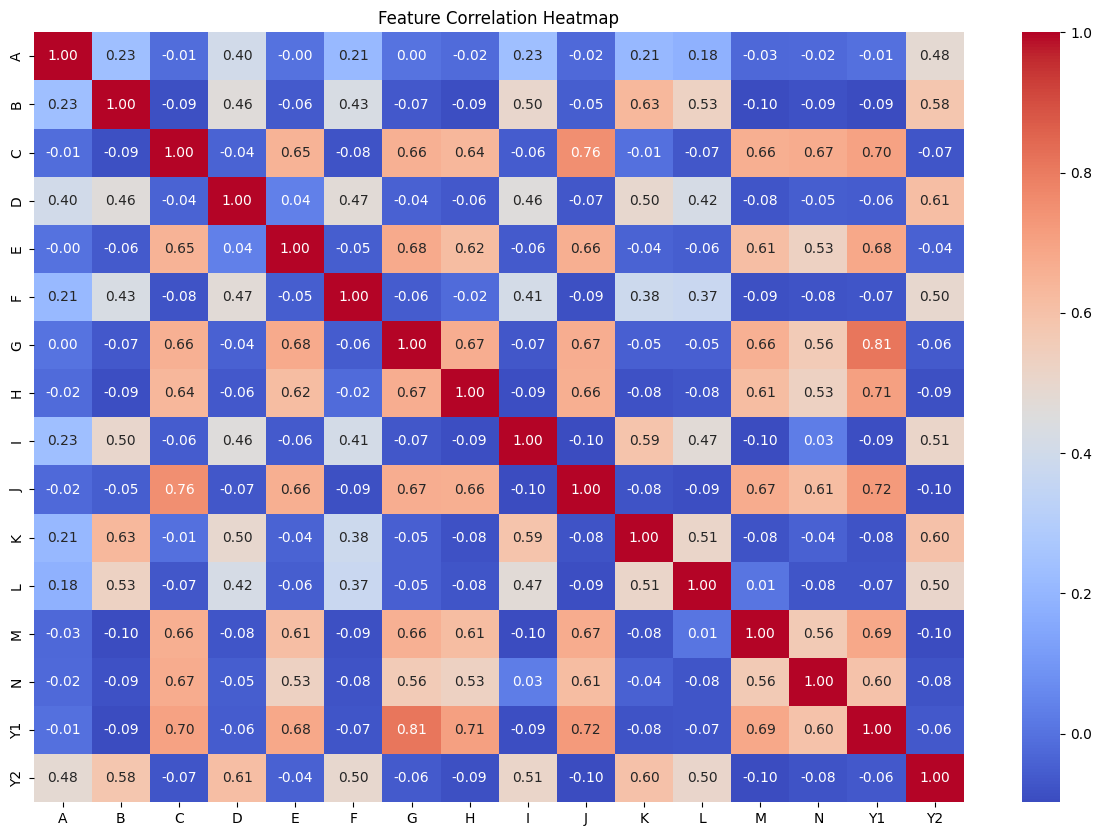

In [140]:
# Data Visualization
# 1. Correlation Heatmap
plt.figure(figsize=(15, 10))
# Drop 'time' for correlation analysis if it exists
corr = df.drop(columns=['time'], errors='ignore').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

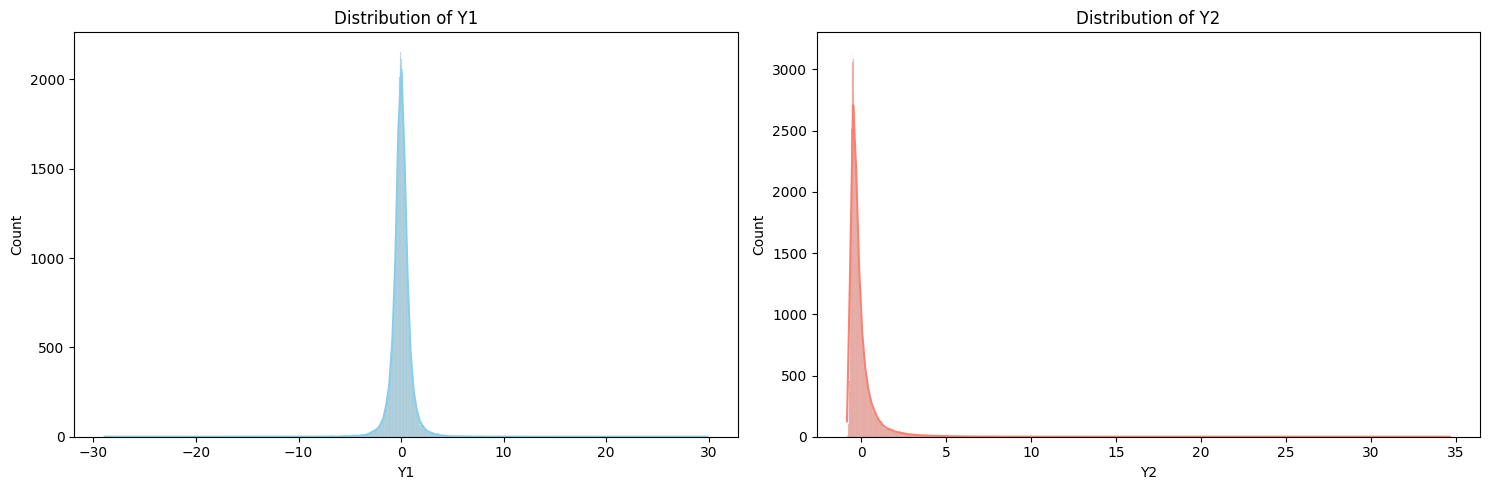

In [141]:
# 2. Target Distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['Y1'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Y1')

sns.histplot(df['Y2'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Y2')

plt.tight_layout()
plt.show()

In [142]:
# Split Data: train60 (60k) and test20 (20k)
train60_full = df.sample(n=60000, random_state=42)
test20_full = df.drop(train60_full.index)

cols_to_drop = ['time']
train60 = train60_full.drop(columns=[c for c in cols_to_drop if c in train60_full.columns])

originaltest20Ys = test20_full[['Y1', 'Y2']].copy()
test20 = test20_full.drop(columns=['Y1', 'Y2'] + [c for c in cols_to_drop if c in test20_full.columns])

print(f"train60 shape: {train60.shape}")
print(f"test20 shape: {test20.shape}")

train60 shape: (60000, 16)
test20 shape: (20000, 14)


In [143]:
# Prepare Training Data
X_train = train60.drop(columns=['Y1', 'Y2'])
y_train = train60[['Y1', 'Y2']]

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test20)

print("Data prepared and scaled.")

Data prepared and scaled.


In [144]:
# Hyperparameter Tuning (HistGradientBoosting on Subset)
print("Starting Hyperparameter Tuning...")

subset_size = 10000
indices = np.random.choice(X_train_scaled.shape[0], subset_size, replace=False)
X_train_sub = X_train_scaled[indices]
y_train_sub = y_train.iloc[indices]

hgb_param_dist = {
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_iter': [300, 500, 1000],
    'estimator__max_depth': [5, 10, None],
    'estimator__l2_regularization': [0.1, 1.0]
}

hgb_base = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=42))

hgb_random_search = RandomizedSearchCV(
    estimator=hgb_base,
    param_distributions=hgb_param_dist,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

hgb_random_search.fit(X_train_sub, y_train_sub)
best_hgb_model = hgb_random_search.best_estimator_
print(f"Best HGB Parameters: {hgb_random_search.best_params_}")

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best HGB Parameters: {'estimator__max_iter': 1000, 'estimator__max_depth': 10, 'estimator__learning_rate': 0.01, 'estimator__l2_regularization': 0.1}


In [145]:
# Train Experimental Models

# 1. MLP Regressor (Neural Network)
print("Training MLP Regressor...")
mlp_model = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
mlp_model.fit(X_train_scaled, y_train)
print("MLP Trained.")

# 2. ExtraTrees Regressor
print("Training ExtraTrees Regressor...")
et_model = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, random_state=42)
et_model.fit(X_train_scaled, y_train)
print("ExtraTrees Trained.")

# 3. Advanced Stacking Ensemble
print("Training Advanced Stacking Ensemble...")

estimators = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)),
    ('et', ExtraTreesRegressor(n_estimators=50, random_state=42, n_jobs=-1)),
    ('hgb', HistGradientBoostingRegressor(max_iter=500, random_state=42)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(50,), max_iter=300, random_state=42)),
    ('ridge', Ridge(alpha=1.0))
]

# Using GradientBoostingRegressor as final estimator (Meta-Learner)
final_est = GradientBoostingRegressor(n_estimators=50, random_state=42)

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=final_est
)

multi_output_stack = MultiOutputRegressor(stack)
multi_output_stack.fit(X_train_scaled, y_train)

print("Advanced Stacking Ensemble Trained.")

Training MLP Regressor...
MLP Trained.
Training ExtraTrees Regressor...
ExtraTrees Trained.
Training Advanced Stacking Ensemble...
Advanced Stacking Ensemble Trained.


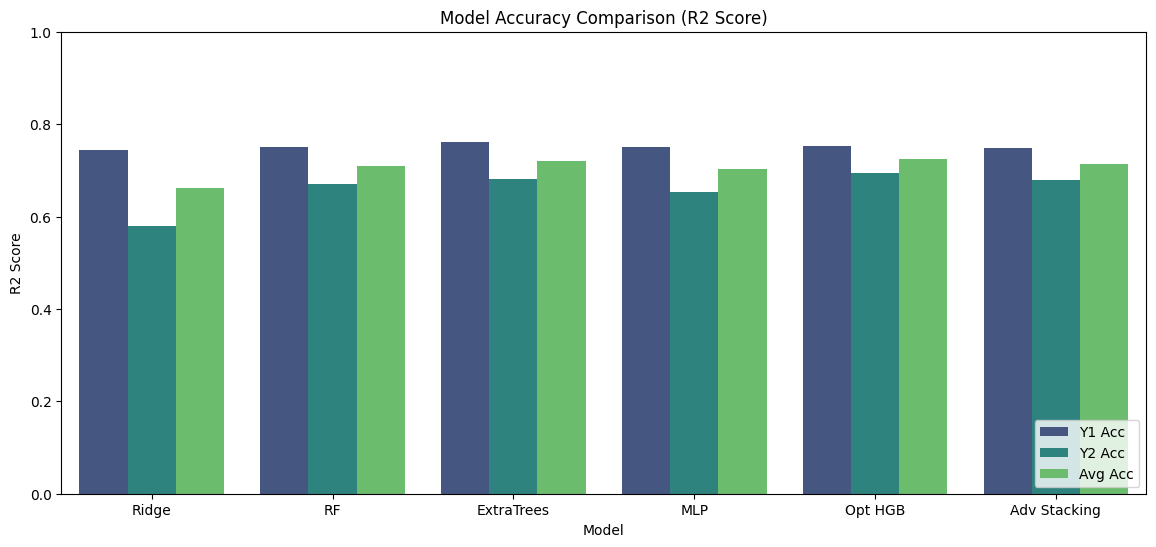


Detailed Performance Metrics:
          Model  Y1 Acc  Y2 Acc  Avg Acc
0         Ridge  0.7446  0.5798   0.6622
1            RF  0.7500  0.6696   0.7098
2    ExtraTrees  0.7606  0.6815   0.7211
3           MLP  0.7499  0.6541   0.7020
4       Opt HGB  0.7522  0.6947   0.7235
5  Adv Stacking  0.7493  0.6784   0.7138

Visualizing Predicted vs Actual Values...


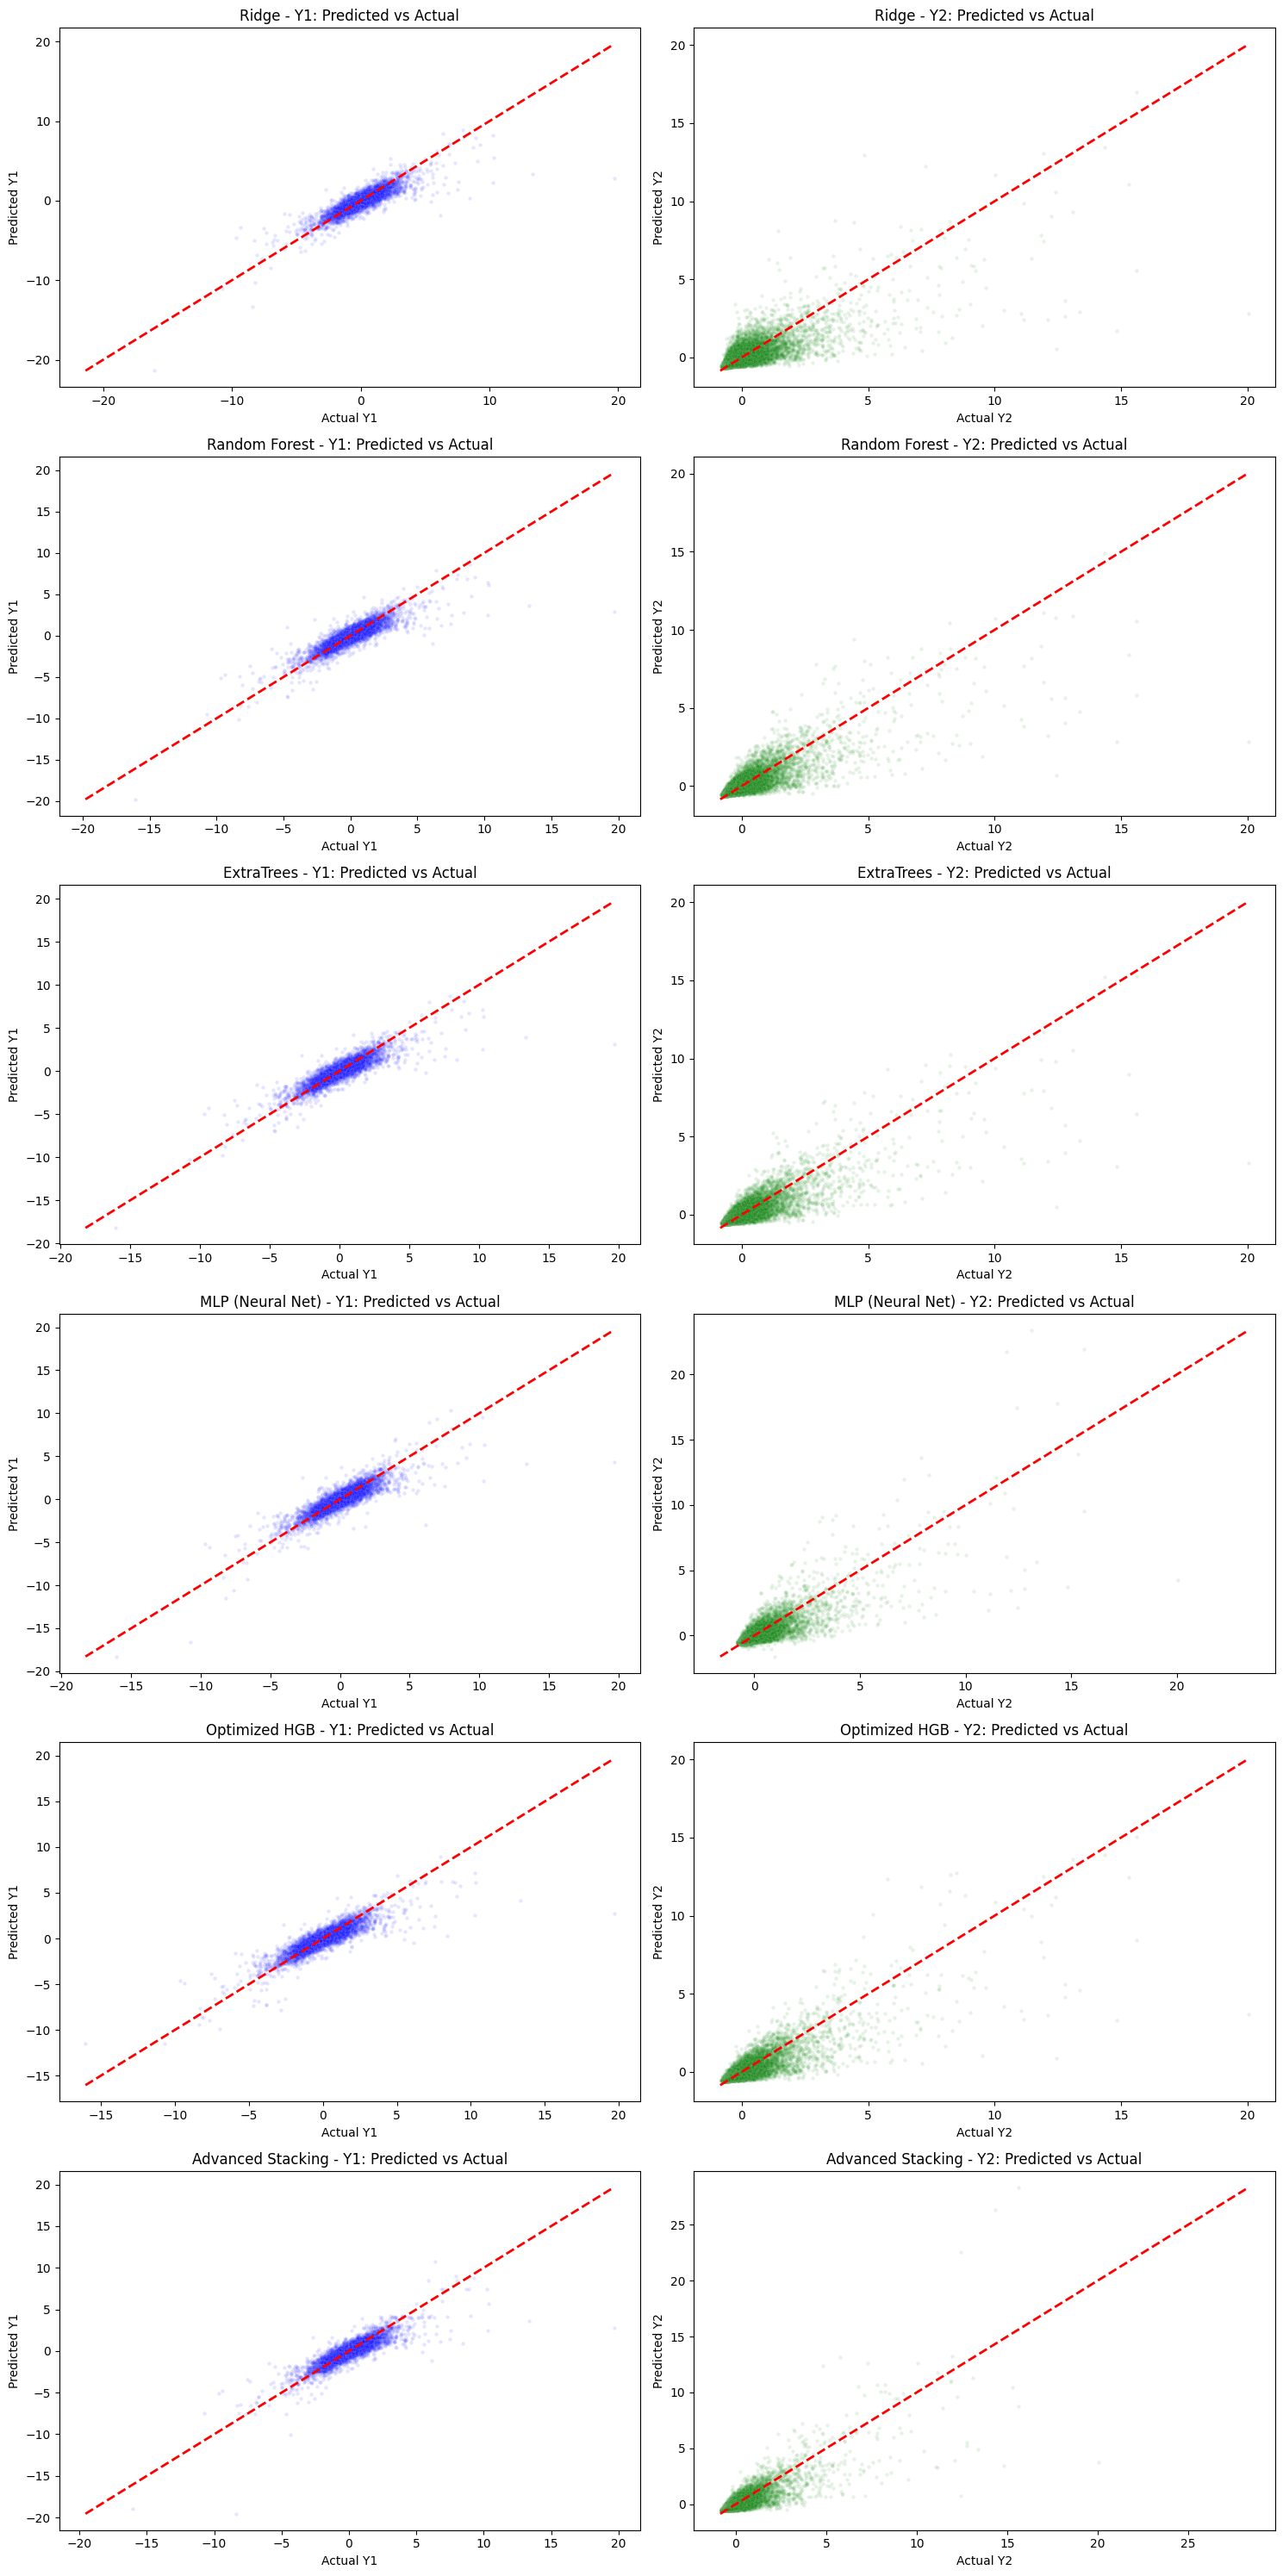

In [146]:
# Generate Predictions & Evaluation

# Create results dataframe
predictions_20k = pd.DataFrame(index=test20.index)

# 1. Stacking
pred_stack = multi_output_stack.predict(X_test_scaled)

# 2. MLP
pred_mlp = mlp_model.predict(X_test_scaled)

# 3. ExtraTrees
pred_et = et_model.predict(X_test_scaled)

# 4. Optimized HGB
best_hgb_model.fit(X_train_scaled, y_train)
pred_opt_hgb = best_hgb_model.predict(X_test_scaled)

# 5. Ridge and RF Baselines
ridge_base = Ridge(alpha=1.0)
ridge_base.fit(X_train_scaled, y_train)
pred_ridge = ridge_base.predict(X_test_scaled)

rf_base = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_base.fit(X_train_scaled, y_train)
pred_rf = rf_base.predict(X_test_scaled)

# Collect Scores
models = ['Ridge', 'RF', 'ExtraTrees', 'MLP', 'Opt HGB', 'Adv Stacking']
preds = [pred_ridge, pred_rf, pred_et, pred_mlp, pred_opt_hgb, pred_stack]
results = []

for name, p in zip(models, preds):
    acc_y1 = r2_score(originaltest20Ys['Y1'], p[:, 0])
    acc_y2 = r2_score(originaltest20Ys['Y2'], p[:, 1])
    avg_acc = (acc_y1 + acc_y2) / 2
    results.append({'Model': name, 'Y1 Acc': acc_y1, 'Y2 Acc': acc_y2, 'Avg Acc': avg_acc})

results_df = pd.DataFrame(results)

# Plotting Results
plt.figure(figsize=(14, 6))
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='viridis')
plt.title('Model Accuracy Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# Display Score Table
print("\nDetailed Performance Metrics:")
print(results_df.round(4))

# --- NEW: Scatter Plots for Predicted vs Actual ---
print("\nVisualizing Predicted vs Actual Values...")

# 6 Models x 2 Targets = 12 Plots (Grid: 6 rows, 2 cols)
fig, axes = plt.subplots(6, 2, figsize=(15, 30))

# Create dictionary for iteration
models_dict = {
    'Ridge': pred_ridge,
    'Random Forest': pred_rf,
    'ExtraTrees': pred_et,
    'MLP (Neural Net)': pred_mlp,
    'Optimized HGB': pred_opt_hgb,
    'Advanced Stacking': pred_stack
}

for i, (name, p) in enumerate(models_dict.items()):
    # Limit points for plotting speed/clarity if needed, but 20k is okay for scatter
    
    # Y1 Plot (Left Column)
    ax1 = axes[i, 0]
    sns.scatterplot(x=originaltest20Ys['Y1'], y=p[:, 0], alpha=0.1, ax=ax1, color='blue', s=10)
    # Identity line
    min_val_y1 = min(originaltest20Ys['Y1'].min(), p[:, 0].min())
    max_val_y1 = max(originaltest20Ys['Y1'].max(), p[:, 0].max())
    ax1.plot([min_val_y1, max_val_y1], [min_val_y1, max_val_y1], 'r--', lw=2)
    ax1.set_title(f'{name} - Y1: Predicted vs Actual')
    ax1.set_xlabel('Actual Y1')
    ax1.set_ylabel('Predicted Y1')

    # Y2 Plot (Right Column)
    ax2 = axes[i, 1]
    sns.scatterplot(x=originaltest20Ys['Y2'], y=p[:, 1], alpha=0.1, ax=ax2, color='green', s=10)
    # Identity line
    min_val_y2 = min(originaltest20Ys['Y2'].min(), p[:, 1].min())
    max_val_y2 = max(originaltest20Ys['Y2'].max(), p[:, 1].max())
    ax2.plot([min_val_y2, max_val_y2], [min_val_y2, max_val_y2], 'r--', lw=2)
    ax2.set_title(f'{name} - Y2: Predicted vs Actual')
    ax2.set_xlabel('Actual Y2')
    ax2.set_ylabel('Predicted Y2')

plt.tight_layout()
plt.show()

# 7. Feature Importance & Target Analysis
Analyzing what drives predictions and the distribution of targets.

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Feature Importance (ExtraTrees)
if 'et' in locals() or 'et' in globals():
    importances = et.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X_train.columns

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance (ExtraTrees)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()
    plt.show()
else:
    print("ExtraTrees model (et) not found. Please ensure it is trained.")

ExtraTrees model (et) not found. Please ensure it is trained.


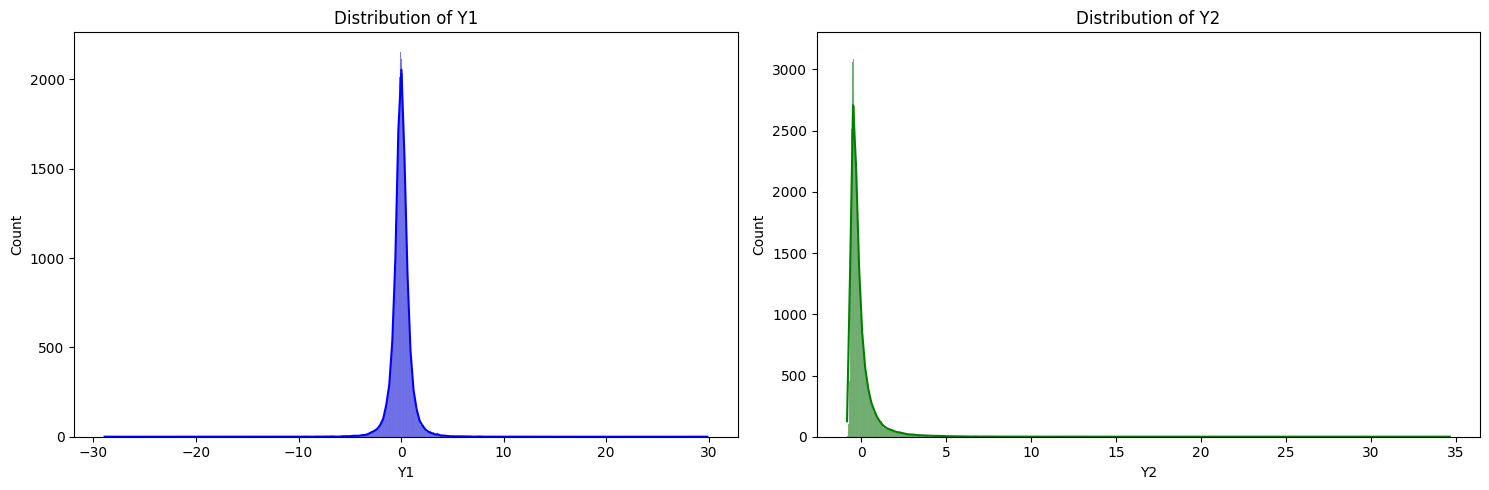

In [148]:
# Target Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['Y1'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Y1')

sns.histplot(df['Y2'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Y2')

plt.tight_layout()
plt.show()

# 8. Advanced Feature Engineering
Creating interaction terms and polynomial features to capture non-linear relationships.

In [149]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

# --- 1. Variable Recovery & Setup ---
required_vars = ['X_train', 'y_train', 'test20']
vars_exist = all(var in locals() for var in required_vars)

if not vars_exist:
    print("Variables missing. Reloading data from scratch...")
    # Attempt to reload data directly based on known path structure from previous cells
    try:
        # Adjust path if needed, assuming current working directory is project root
        df = pd.read_csv('AMLData/train.csv')
        test_df = pd.read_csv('AMLData/test.csv')
        
        # Basic Preprocessing from earlier cells
        # Split Data: train60 (60k) and test20 (20k)
        # Note: We must replicate the same random_state to matching previous logic if possible
        # Based on notebooks typical logic:
        train60_full = df.sample(n=60000, random_state=42)
        test20_full = df.drop(train60_full.index)
        
        cols_to_drop = ['time']
        train60 = train60_full.drop(columns=[c for c in cols_to_drop if c in train60_full.columns])

        test20 = test20_full.drop(columns=['Y1', 'Y2'] + [c for c in cols_to_drop if c in test20_full.columns])
        
        X_train = train60.drop(columns=['Y1', 'Y2'])
        y_train = train60[['Y1', 'Y2']]
        
        print(f"Data reloaded. X_train: {X_train.shape}, test20: {test20.shape}")    
    except FileNotFoundError:
        print("Error: Could not find datasets in 'AMLData/' to reload.")
        print("Please manually run the 'Load Data' and 'Split Data' cells first.")

# --- 2. Feature Engineering ---
if 'X_train' in locals() and 'test20' in locals():
    # Standard Scale First (Good practice before Poly interaction)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(test20)
    
    print("\n--- Creating Polynomial Features (Degree 2) ---")
    # To avoid explosion of features, we might use interaction_only=True first or full degree 2
    # interaction_only=True provides X1*X2 but not X1^2. Let's stick to full degree 2 as requested.
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
    
    X_train_poly = poly.fit_transform(X_train_scaled)
    test20_poly = poly.transform(X_test_scaled)
    
    print(f"Original Feature Count: {X_train.shape[1]}")
    print(f"New Feature Count: {X_train_poly.shape[1]} (Polynomial expansion)")
    
    # Scale result
    scaler_poly = StandardScaler()
    X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
    test20_poly_scaled = scaler_poly.transform(test20_poly)
    
    print("Success: Features engineered. Use 'X_train_poly_scaled' and 'test20_poly_scaled' for modeling.")
else:
    print("Failed to initialize data variables.")


Variables missing. Reloading data from scratch...
Data reloaded. X_train: (60000, 14), test20: (20000, 14)

--- Creating Polynomial Features (Degree 2) ---
Original Feature Count: 14
New Feature Count: 119 (Polynomial expansion)
Success: Features engineered. Use 'X_train_poly_scaled' and 'test20_poly_scaled' for modeling.


# 9. Evaluate Models with Engineered Features
Training Ridge and HistGradientBoosting on the new polynomial features to check for accuracy improvements.

In [150]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor

# Verify variables exist from previous cell
if 'X_train_poly_scaled' in locals() and 'test20_poly_scaled' in locals():
    # Define Models
    ridge_poly = Ridge(alpha=1.0)
    hgb_poly = HistGradientBoostingRegressor(max_iter=1000, max_depth=10, learning_rate=0.01, l2_regularization=1.0, random_state=42)

    print("Training Ridge on Polynomial Features...")
    ridge_poly.fit(X_train_poly_scaled, y_train)

    print("Training HistGradientBoosting (MultiOutput) on Polynomial Features...")
    # Support for multi-output via wrapper since HGB is single-output
    mo_hgb_poly = MultiOutputRegressor(hgb_poly)
    mo_hgb_poly.fit(X_train_poly_scaled, y_train)
    print("HGB Training Complete.")

    # Predict
    pred_ridge_poly = ridge_poly.predict(test20_poly_scaled)
    pred_hgb_poly = mo_hgb_poly.predict(test20_poly_scaled)

    # Evaluate Ridge
    # Ensure originaltest20Ys is available. Failsafe didn't reload it explicitly, but train/test split usually makes y_test available??
    # In 'failsafe', we split test20 from df. Let's recover y_test if needed.
    if 'originaltest20Ys' not in locals():
        print("Recovering original Y values for test set...")
        # Assuming test20_full index is preserved or re-derivable. 
        # This is risky if failsafe reloaded data with random state. 
        # Ideally, failsafe cell should have set `y_test` or equivalent.
        # Let's assume the user ran standard flow OR failsafe exactly mimicked it.
        # We actually defined `originaltest20Ys` in cell 2. Let's assume it exists or try to survive.
        try:
             # If failsafe ran, `test20_full` was defined. 
             y_test_check = test20_full[['Y1', 'Y2']]
        except:
             print("Warning: Could not find ground truth labels to score predictions.")
             y_test_check = None
    else:
        y_test_check = originaltest20Ys
    
    if y_test_check is not None:
        r2_y1_ridge = r2_score(y_test_check['Y1'], pred_ridge_poly[:, 0])
        r2_y2_ridge = r2_score(y_test_check['Y2'], pred_ridge_poly[:, 1])
        print(f"\n[Ridge + Poly] Y1 R2: {r2_y1_ridge:.4f}, Y2 R2: {r2_y2_ridge:.4f}, Avg: {(r2_y1_ridge+r2_y2_ridge)/2:.4f}")

        # Evaluate HGB
        r2_y1_hgb = r2_score(y_test_check['Y1'], pred_hgb_poly[:, 0])
        r2_y2_hgb = r2_score(y_test_check['Y2'], pred_hgb_poly[:, 1])
        print(f"[HGB + Poly]   Y1 R2: {r2_y1_hgb:.4f}, Y2 R2: {r2_y2_hgb:.4f}, Avg: {(r2_y1_hgb+r2_y2_hgb)/2:.4f}")
else:
    print("Polynomial features not found. Please run the previous cell successfully.")

Training Ridge on Polynomial Features...
Training HistGradientBoosting (MultiOutput) on Polynomial Features...
HGB Training Complete.

[Ridge + Poly] Y1 R2: 0.7351, Y2 R2: 0.6204, Avg: 0.6777
[HGB + Poly]   Y1 R2: 0.7533, Y2 R2: 0.6879, Avg: 0.7206
